In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import bottleneck as bn
from functools import reduce
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import lightgbm as lgb

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 100)
np.set_printoptions(suppress=True)

# Resolve root directory
ROOT_DIR = Path(".").resolve().parent

In [4]:
# Load the data
data_path = ROOT_DIR / "task1" / "example" / "data"
train = pd.read_csv(data_path / "train.csv", parse_dates=["date"])
test = pd.read_csv(data_path / "test.csv", parse_dates=["date"])
coords = pd.read_csv(data_path / "coords.csv")

In [5]:
# Explore the data
print(f"Train shape: {train.shape}")
print(f"Date range: {train['date'].min()} to {train['date'].max()}")
print(f"Unique categories: {train['cat'].nunique()}")
print(f"Groups: {train['group'].unique()}")
train.head()

Train shape: (82392, 10)
Date range: 2020-02-01 00:00:00 to 2048-01-01 00:00:00
Unique categories: 447
Groups: ['P' 'I']


,cat,date,gor,gas,oil,watercut,water,bhp,group,water_inj
0,hw-3,2020-02-01,731.414978,3.660375e+06,5004.512533,0.000043,0.002136,3274.055729,P,NaN
1,hw-3,2020-03-01,731.414978,3.782299e+06,5171.207386,0.000022,0.001117,3237.286417,P,NaN
2,hw-3,2020-04-01,731.414978,3.571577e+06,4883.105894,0.000014,0.000673,3221.117826,P,NaN
3,hw-3,2020-05-01,731.414978,3.653935e+06,4995.706858,0.000044,0.002196,3196.397707,P,NaN
4,hw-3,2020-06-01,731.414978,3.611093e+06,4937.133294,0.000101,0.004971,3187.041537,P,NaN


In [6]:
# Pivot the train data to get it in wide format for rolling calculations
data = train.pivot_table(index="date", columns="cat", values="oil")
data.head()

cat,hw-10,hw-24,hw-25,hw-26,hw-27,hw-28,hw-29,hw-3,hw-30,hw-31,hw-32,hw-4,hw-5,hw-6,hw-7,hw-8,hw-9,well-1,well-10,well-100,well-101,well-102,well-103,well-104,well-105,well-106,well-107,well-108,well-109,well-11,well-110,well-111,well-112,well-113,well-114,well-115,well-116,well-117,well-118,well-119,well-12,well-120,well-121,well-122,well-123,well-124,well-125,well-126,well-127,well-128,well-129,well-13,well-130,well-131,well-132,well-133,well-134,well-135,well-136,well-137,well-138,well-139,well-14,well-140,well-141,well-142,well-143,well-144,well-145,well-146,well-147,well-148,well-149,well-15,well-150,well-151,well-152,well-153,well-154,well-155,well-156,well-157,well-158,well-159,well-16,well-160,well-161,well-162,well-163,well-164,well-165,well-166,well-167,well-168,well-169,well-17,well-170,well-171,well-172,well-173,well-174,well-175,well-176,well-177,well-178,well-179,well-18,well-180,well-181,well-182,well-183,well-184,well-185,well-186,well-187,well-188,well-189,well-19,well-190,well-191,well-192,well-193,well-194,well-195,well-196,well-197,well-198,well-199,well-2,well-20,well-200,well-201,well-202,well-203,well-204,well-205,well-206,well-207,well-208,well-209,well-21,well-210,well-211,well-212,well-213,well-214,well-215,well-216,well-217,well-218,well-219,well-22,well-220,well-221,well-222,well-223,well-224,well-225,well-226,well-227,well-228,well-229,well-23,well-230,well-231,well-232,well-233,well-234,well-235,well-236,well-237,well-238,well-239,well-24,well-240,well-241,well-242,well-243,well-244,well-245,well-246,well-247,well-248,well-25,well-26,well-27,well-28,well-29,well-3,well-30,well-31,well-32,well-33,well-34,well-35,well-36,well-37,well-38,well-39,well-4,well-40,well-41,well-42,well-43,well-44,well-45,well-46,well-47,well-48,well-49,well-5,well-50,well-51,well-52,well-53,well-54,well-55,well-56,well-57,well-58,well-59,well-6,well-60,well-61,well-62,well-63,well-64,well-65,well-66,well-67,well-68,well-69,well-7,well-70,well-71,well-72,well-73,well-74,well-75,well-76,well-77,well-78,well-79,well-8,well-80,well-81,well-82,well-83,well-84,well-85,well-86,well-87,well-88,well-89,well-9,well-90,well-91,well-92,well-93,well-94,well-95,well-96,well-97,well-98,well-99
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,2622.960641,3112.100243,2577.727751,79.304023,0.0,2427.483659,4957.311651,5004.512533,5035.078571,0.0,5029.845714,0.0,0.0,5063.537081,0.0,0.0,853.500150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,2395.298452,2782.798494,2595.218306,66.973557,0.0,1814.193666,4847.876930,5171.207386,4832.662574,0.0,4968.389120,0.0,0.0,5013.735467,0.0,0.0,510.423406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [7]:
# Create future dates for the forecast horizon
HORIZON = 24
max_date = data.index.max()
future_dates = pd.date_range(start=max_date, periods=HORIZON + 1, freq="MS")
new_index = data.index.append(future_dates)
data_extended = data.reindex(new_index)
print(f"Extended data shape: {data_extended.shape}")

Extended data shape: (361, 265)


In [8]:
# Function to compute rolling statistics using bottleneck
def bottleneck_stats(
    series, periods=1, min_count=1, window=4, fillna=None, aggfunc="mean"
):
    def shift(xs, n):
        return np.concatenate((np.full(n, np.nan), xs[:-n]))

    arr = series.values
    arr = shift(xs=arr, n=periods)

    if aggfunc == "mean":
        arr = bn.move_mean(arr, window=window, min_count=min_count)
    elif aggfunc == "std":
        arr = bn.move_std(arr, window=window, min_count=min_count)
    elif aggfunc == "sum":
        arr = bn.move_sum(arr, window=window, min_count=min_count)
    elif aggfunc == "median":
        arr = bn.move_median(arr, window=window, min_count=min_count)
    elif aggfunc == "diff":
        min_arr = bn.move_min(arr, window=window, min_count=min_count)
        max_arr = bn.move_max(arr, window=window, min_count=min_count)
        arr = max_arr - min_arr
    elif aggfunc == "min":
        arr = bn.move_min(arr, window=window, min_count=min_count)
    elif aggfunc == "max":
        arr = bn.move_max(arr, window=window, min_count=min_count)

    features = pd.Series(arr)
    features.index = series.index

    if fillna is not None:
        features.fillna(fillna, inplace=True)

    return features

In [9]:
# Calculate rolling statistics with multiple windows
segments_list = data_extended.columns.tolist()

# Window 24 features
rolling_mean_24 = data_extended.copy()
rolling_std_24 = data_extended.copy()
rolling_median_24 = data_extended.copy()
rolling_diff_24 = data_extended.copy()
rolling_min_24 = data_extended.copy()
rolling_max_24 = data_extended.copy()

# Window 12 features
rolling_mean_12 = data_extended.copy()
rolling_std_12 = data_extended.copy()
rolling_diff_12 = data_extended.copy()

# Window 6 features
rolling_mean_6 = data_extended.copy()
rolling_std_6 = data_extended.copy()

# Exponential weighted mean
rolling_ewm = data_extended.copy()

for i in segments_list:
    # Window 24
    rolling_mean_24[i] = bottleneck_stats(rolling_mean_24[i], window=24, min_count=1, aggfunc='mean')
    rolling_std_24[i] = bottleneck_stats(rolling_std_24[i], window=24, min_count=1, aggfunc='std')
    rolling_median_24[i] = bottleneck_stats(rolling_median_24[i], window=24, min_count=1, aggfunc='median')
    rolling_diff_24[i] = bottleneck_stats(rolling_diff_24[i], window=24, min_count=1, aggfunc='diff')
    rolling_min_24[i] = bottleneck_stats(rolling_min_24[i], window=24, min_count=1, aggfunc='min')
    rolling_max_24[i] = bottleneck_stats(rolling_max_24[i], window=24, min_count=1, aggfunc='max')

    # Window 12
    rolling_mean_12[i] = bottleneck_stats(rolling_mean_12[i], window=12, min_count=1, aggfunc='mean')
    rolling_std_12[i] = bottleneck_stats(rolling_std_12[i], window=12, min_count=1, aggfunc='std')
    rolling_diff_12[i] = bottleneck_stats(rolling_diff_12[i], window=12, min_count=1, aggfunc='diff')

    # Window 6
    rolling_mean_6[i] = bottleneck_stats(rolling_mean_6[i], window=6, min_count=1, aggfunc='mean')
    rolling_std_6[i] = bottleneck_stats(rolling_std_6[i], window=6, min_count=1, aggfunc='std')

    # EWM
    rolling_ewm[i] = rolling_ewm[i].ewm(alpha=0.15).mean()

print("Rolling statistics calculated")

Rolling statistics calculated


In [10]:
# Fill NaN values with 0
rolling_dfs = [
    rolling_mean_24, rolling_std_24, rolling_median_24, rolling_diff_24,
    rolling_min_24, rolling_max_24, rolling_mean_12, rolling_std_12,
    rolling_diff_12, rolling_mean_6, rolling_std_6, rolling_ewm
]
for df in rolling_dfs:
    df.fillna(0, inplace=True)

In [11]:
# Add date column for melting
rolling_mean_24["date"] = rolling_mean_24.index
rolling_std_24["date"] = rolling_std_24.index
rolling_median_24["date"] = rolling_median_24.index
rolling_diff_24["date"] = rolling_diff_24.index
rolling_min_24["date"] = rolling_min_24.index
rolling_max_24["date"] = rolling_max_24.index
rolling_mean_12["date"] = rolling_mean_12.index
rolling_std_12["date"] = rolling_std_12.index
rolling_diff_12["date"] = rolling_diff_12.index
rolling_mean_6["date"] = rolling_mean_6.index
rolling_std_6["date"] = rolling_std_6.index
rolling_ewm["date"] = rolling_ewm.index

/var/folders/m2/7bl40zvx2sq7_zrk_22jw7r80000gn/T/ipykernel_64830/3449493365.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rolling_mean_24["date"] = rolling_mean_24.index
/var/folders/m2/7bl40zvx2sq7_zrk_22jw7r80000gn/T/ipykernel_64830/3449493365.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rolling_std_24["date"] = rolling_std_24.index
/var/folders/m2/7bl40zvx2sq7_zrk_22jw7r80000gn/T/ipykernel_64830/3449493365.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

In [12]:
# Melt all rolling statistics dataframes
rolling_mean_24_m = rolling_mean_24.melt(id_vars='date', var_name='cat', value_name='rolling_mean_24')
rolling_std_24_m = rolling_std_24.melt(id_vars='date', var_name='cat', value_name='rolling_std_24')
rolling_median_24_m = rolling_median_24.melt(id_vars='date', var_name='cat', value_name='rolling_median_24')
rolling_diff_24_m = rolling_diff_24.melt(id_vars='date', var_name='cat', value_name='rolling_diff_24')
rolling_min_24_m = rolling_min_24.melt(id_vars='date', var_name='cat', value_name='rolling_min_24')
rolling_max_24_m = rolling_max_24.melt(id_vars='date', var_name='cat', value_name='rolling_max_24')
rolling_mean_12_m = rolling_mean_12.melt(id_vars='date', var_name='cat', value_name='rolling_mean_12')
rolling_std_12_m = rolling_std_12.melt(id_vars='date', var_name='cat', value_name='rolling_std_12')
rolling_diff_12_m = rolling_diff_12.melt(id_vars='date', var_name='cat', value_name='rolling_diff_12')
rolling_mean_6_m = rolling_mean_6.melt(id_vars='date', var_name='cat', value_name='rolling_mean_6')
rolling_std_6_m = rolling_std_6.melt(id_vars='date', var_name='cat', value_name='rolling_std_6')
rolling_ewm_m = rolling_ewm.melt(id_vars='date', var_name='cat', value_name='rolling_ewm')

In [13]:
# Concatenate train and test data
data_combined = pd.concat([train, test], axis=0)
data_combined.reset_index(drop=True, inplace=True)
print(f"Combined data shape: {data_combined.shape}")

Combined data shape: (93120, 10)


In [14]:
# Merge all features into a single dataframe
data_frames = [
    data_combined,
    rolling_mean_24_m, rolling_std_24_m, rolling_median_24_m, rolling_diff_24_m,
    rolling_min_24_m, rolling_max_24_m,
    rolling_mean_12_m, rolling_std_12_m, rolling_diff_12_m,
    rolling_mean_6_m, rolling_std_6_m,
    rolling_ewm_m
]
data_merged = reduce(lambda left, right: pd.merge(left, right, how='left', on=['cat', 'date']), data_frames)

# Add coordinates
data_merged = pd.merge(data_merged, coords, how='left', on='cat')

print(f"Merged data shape: {data_merged.shape}")
data_merged.head()

Merged data shape: (1178295, 24)


,cat,date,gor,gas,oil,watercut,water,bhp,group,water_inj,rolling_mean_24,rolling_std_24,rolling_median_24,rolling_diff_24,rolling_min_24,rolling_max_24,rolling_mean_12,rolling_std_12,rolling_diff_12,rolling_mean_6,rolling_std_6,rolling_ewm,x,y
0,hw-3,2020-02-01,731.414978,3.660375e+06,5004.512533,0.000043,0.002136,3274.055729,P,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5004.512533,52211.0,84211.0
1,hw-3,2020-03-01,731.414978,3.782299e+06,5171.207386,0.000022,0.001117,3237.286417,P,NaN,5004.512533,0.000000,5004.512533,0.000000,5004.512533,5004.512533,5004.512533,0.000000,0.000000,5004.512533,0.000000,5094.617859,52211.0,84211.0
2,hw-3,2020-04-01,731.414978,3.571577e+06,4883.105894,0.000014,0.000673,3221.117826,P,NaN,5087.859959,83.347427,5087.859959,166.694854,5004.512533,5171.207386,5087.859959,83.347427,166.694854,5087.859959,83.347427,5012.397464,52211.0,84211.0
3,hw-3,2020-05-01,731.414978,3.653935e+06,4995.706858,0.000044,0.002196,3196.397707,P,NaN,5019.608604,118.100342,5004.512533,288.101493,4883.105894,5171.207386,5019.608604,118.100342,288.101493,5019.608604,118.100342,5007.159758,52211.0,84211.0
4,hw-3,2020-06-01,731.414978,3.611093e+06,4937.133294,0.000101,0.004971,3187.041537,P,NaN,5013.633168,102.800222,5000.109695,288.101493,4883.105894,5171.207386,5013.633168,102.800222,288.101493,5013.633168,102.800222,4988.277734,52211.0,84211.0


In [15]:
# Add time-based features
data_merged['month'] = data_merged['date'].dt.month
data_merged['year'] = data_merged['date'].dt.year
data_merged['quarter'] = data_merged['date'].dt.quarter

# Create trend feature (months since start)
min_date = data_merged['date'].min()
data_merged['trend'] = ((data_merged['date'] - min_date).dt.days / 30).astype(int)

print("Time features added")
data_merged.head()

Time features added


,cat,date,gor,gas,oil,watercut,water,bhp,group,water_inj,rolling_mean_24,rolling_std_24,rolling_median_24,rolling_diff_24,rolling_min_24,rolling_max_24,rolling_mean_12,rolling_std_12,rolling_diff_12,rolling_mean_6,rolling_std_6,rolling_ewm,x,y,month,year,quarter,trend
0,hw-3,2020-02-01,731.414978,3.660375e+06,5004.512533,0.000043,0.002136,3274.055729,P,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5004.512533,52211.0,84211.0,2,2020,1,0
1,hw-3,2020-03-01,731.414978,3.782299e+06,5171.207386,0.000022,0.001117,3237.286417,P,NaN,5004.512533,0.000000,5004.512533,0.000000,5004.512533,5004.512533,5004.512533,0.000000,0.000000,5004.512533,0.000000,5094.617859,52211.0,84211.0,3,2020,1,0
2,hw-3,2020-04-01,731.414978,3.571577e+06,4883.105894,0.000014,0.000673,3221.117826,P,NaN,5087.859959,83.347427,5087.859959,166.694854,5004.512533,5171.207386,5087.859959,83.347427,166.694854,5087.859959,83.347427,5012.397464,52211.0,84211.0,4,2020,2,2
3,hw-3,2020-05-01,731.414978,3.653935e+06,4995.706858,0.000044,0.002196,3196.397707,P,NaN,5019.608604,118.100342,5004.512533,288.101493,4883.105894,5171.207386,5019.608604,118.100342,288.101493,5019.608604,118.100342,5007.159758,52211.0,84211.0,5,2020,2,3
4,hw-3,2020-06-01,731.414978,3.611093e+06,4937.133294,0.000101,0.004971,3187.041537,P,NaN,5013.633168,102.800222,5000.109695,288.101493,4883.105894,5171.207386,5013.633168,102.800222,288.101493,5013.633168,102.800222,4988.277734,52211.0,84211.0,6,2020,2,4


In [16]:
# Split data into train and test sets
train_data = data_merged[data_merged['date'] < '2048-02-01'].copy()
test_data = data_merged[data_merged['date'] >= '2048-02-01'].copy()

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1167567, 28)
Test data shape: (10728, 28)


In [17]:
# Further split train into training and validation sets
tr = train_data[train_data['date'] < '2046-02-01'].copy()
val = train_data[train_data['date'] >= '2046-02-01'].copy()

print(f"Training set shape: {tr.shape}")
print(f"Validation set shape: {val.shape}")

Training set shape: (71664, 28)
Validation set shape: (1095903, 28)


In [18]:
# Filter out injection wells (group == 'I') for production forecasting
tr_filtered = tr[tr['group'] != 'I'].copy()
val_filtered = val[val['group'] != 'I'].copy()

print(f"Training set (filtered): {tr_filtered.shape}")
print(f"Validation set (filtered): {val_filtered.shape}")

Training set (filtered): (41268, 28)
Validation set (filtered): (1091535, 28)


In [19]:
# Define columns to drop for modeling
cols_to_drop = ['cat', 'date', 'group', 'water_inj', 'gor', 'gas', 'watercut', 'water', 'bhp']

In [20]:
# Prepare training and validation data
tr_copy = tr_filtered.copy()
val_copy = val_filtered.copy()

X_tr = tr_copy.drop(cols_to_drop + ['oil'], axis=1)
y_tr = tr_copy['oil']

X_val = val_copy.drop(cols_to_drop + ['oil'], axis=1)
y_val = val_copy['oil']

print(f"X_tr shape: {X_tr.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Features: {X_tr.columns.tolist()}")

X_tr shape: (41268, 18)
X_val shape: (1091535, 18)
Features: ['rolling_mean_24', 'rolling_std_24', 'rolling_median_24', 'rolling_diff_24', 'rolling_min_24', 'rolling_max_24', 'rolling_mean_12', 'rolling_std_12', 'rolling_diff_12', 'rolling_mean_6', 'rolling_std_6', 'rolling_ewm', 'x', 'y', 'month', 'year', 'quarter', 'trend']


In [21]:
# Train LightGBM model
lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 500,
    'early_stopping_rounds': 50,
}

model = lgb.LGBMRegressor(**lgb_params)
model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
)

# Make predictions
tr_pred = model.predict(X_tr)
val_pred = model.predict(X_val)

mae_tr = mean_absolute_error(y_tr, tr_pred)
mae_val = mean_absolute_error(y_val, val_pred)

print(f'MAE train: {mae_tr:.2f}')
print(f'MAE validation: {mae_val:.2f}')

MAE train: 38.37
MAE validation: 44.08


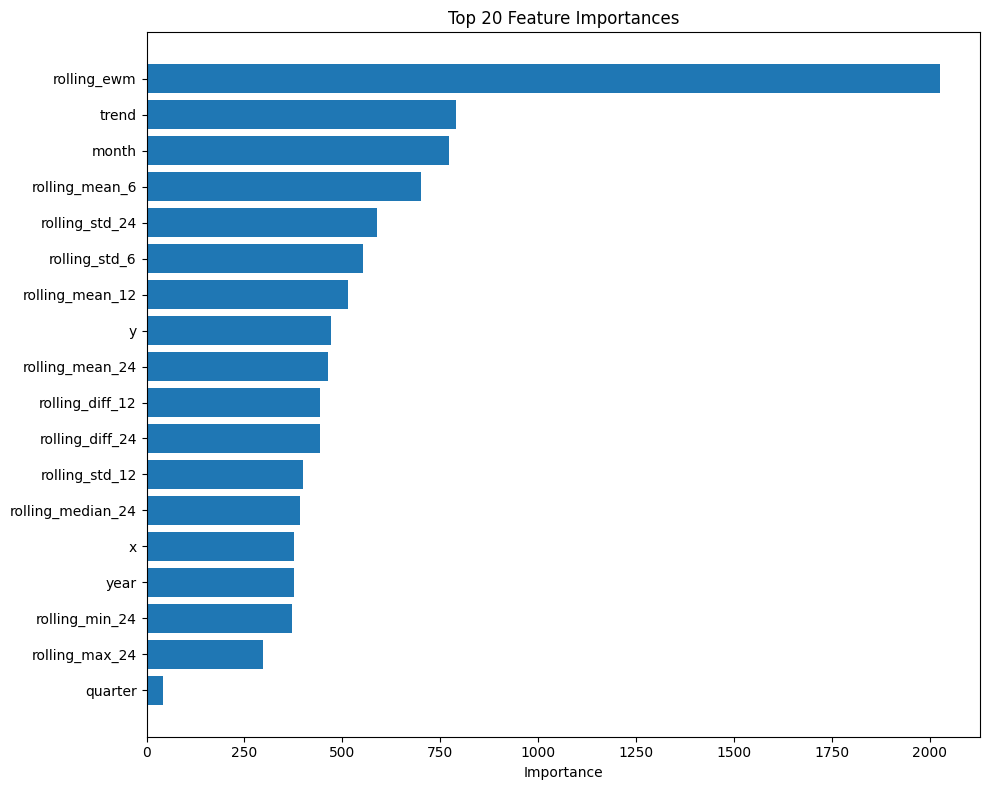

,feature,importance
11,rolling_ewm,2027
17,trend,789
14,month,772
9,rolling_mean_6,701
1,rolling_std_24,588
10,rolling_std_6,553
6,rolling_mean_12,514
13,y,470
0,rolling_mean_24,463
8,rolling_diff_12,443


In [22]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_tr.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance.head(20)

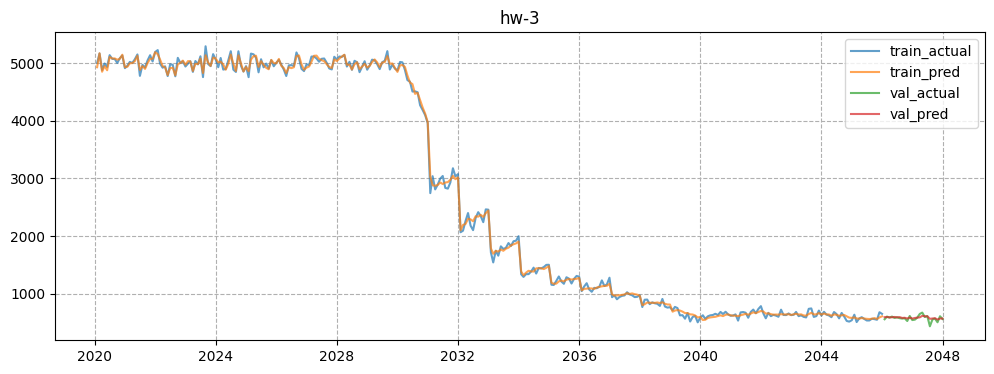

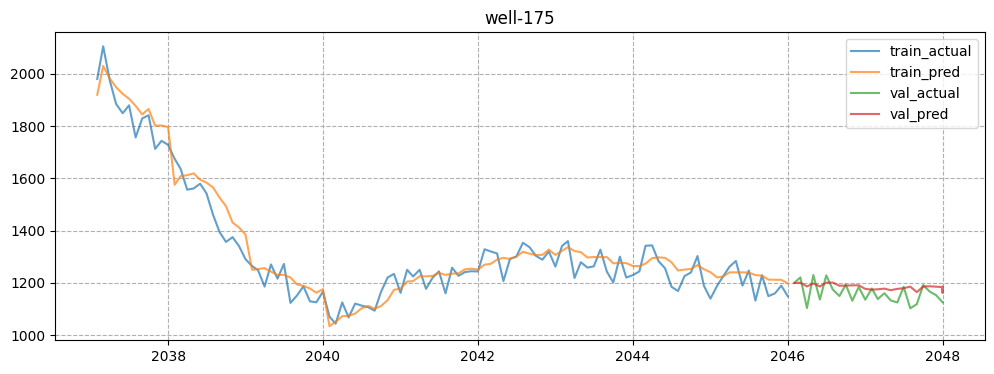

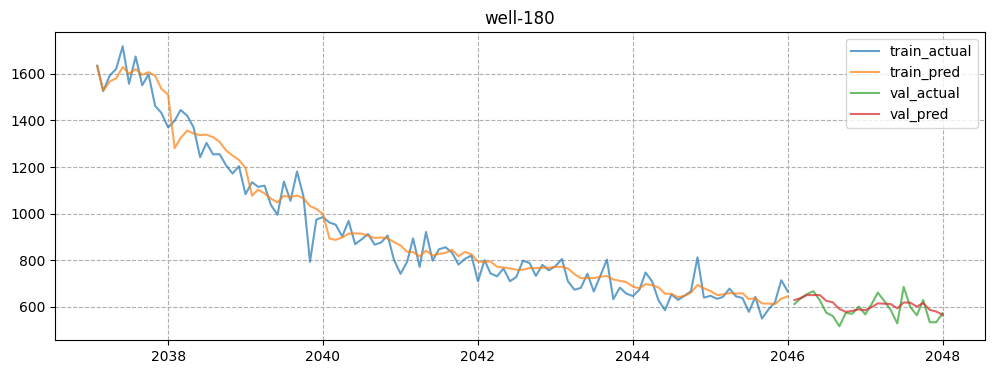

In [23]:
# Visualize predictions for some wells
tr_copy['pred'] = tr_pred
val_copy['pred'] = val_pred

cats_to_plot = ['hw-3', 'well-175', 'well-180']
for cat in cats_to_plot:
    plt.figure(figsize=(12, 4))
    plt.title(cat)

    df_tr = tr_copy[tr_copy['cat'] == cat]
    df_val = val_copy[val_copy['cat'] == cat]

    plt.plot(df_tr['date'], df_tr['oil'], label='train_actual', alpha=0.7)
    plt.plot(df_tr['date'], df_tr['pred'], label='train_pred', alpha=0.7)
    plt.plot(df_val['date'], df_val['oil'], label='val_actual', alpha=0.7)
    plt.plot(df_val['date'], df_val['pred'], label='val_pred', alpha=0.7)

    plt.legend()
    plt.grid(ls='--')
    plt.show()

In [24]:
# Prepare final training on full train data and predict test
train_final = train_data[train_data['group'] != 'I'].copy()
test_final = test_data[test_data['group'] != 'I'].copy()

X_train_final = train_final.drop(cols_to_drop + ['oil'], axis=1)
y_train_final = train_final['oil']

X_test_final = test_final.drop(cols_to_drop + ['oil'], axis=1)

print(f"Final training shape: {X_train_final.shape}")
print(f"Final test shape: {X_test_final.shape}")

Final training shape: (1132803, 18)
Final test shape: (6360, 18)


In [25]:
# Train final model on all training data
final_lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 300,
}

final_model = lgb.LGBMRegressor(**final_lgb_params)
final_model.fit(X_train_final, y_train_final)

# Make predictions on test data
test_predictions = final_model.predict(X_test_final)
print(f"Predictions generated: {len(test_predictions)}")

Predictions generated: 6360


In [27]:
# Create submission file
submission = test_final[['cat', 'date']].copy()
submission['fcst'] = test_predictions

# Ensure non-negative predictions
submission['fcst'] = submission['fcst'].clip(lower=0)

output_path = Path(".").resolve().parent / "pred.csv"
submission.to_csv(output_path, index=False)
print(f"Submission saved to {output_path}")
submission.head(20)

Submission saved to /Users/mac/dev/oil-gas-labs/pred.csv


,cat,date,fcst
1167567,hw-3,2048-02-01,561.717304
1167568,hw-3,2048-03-01,560.398493
1167569,hw-3,2048-04-01,556.036090
1167570,hw-3,2048-05-01,580.821653
1167571,hw-3,2048-06-01,561.165867
1167572,hw-3,2048-07-01,563.641521
1167573,hw-3,2048-08-01,364.797039
1167574,hw-3,2048-09-01,357.578676
1167575,hw-3,2048-10-01,360.914005
1167576,hw-3,2048-11-01,365.901378


In [28]:
# Summary statistics of predictions
print("Prediction statistics:")
print(submission['fcst'].describe())

Prediction statistics:
count    6360.000000
mean      844.420538
std       645.251737
min         0.000000
25%       388.779930
50%       686.277437
75%      1023.623807
max      3464.067378
Name: fcst, dtype: float64
